## 10.4. Bahdanau Attention
没有对齐方向限制的可区分的注意力模型。通过将上下文变量视为注意力池化的输出来实现的。
### 10.4.1. Model
假设输入序列有 $T$ 个标记，在每一个解码的时间步 $t'$ 上下文变量作为注意力池化的输出：

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

其中，解码器的隐藏状态 $\mathbf{s}_{t' - 1}$ 在时间步 $t'-1$时作为查询，编码器的隐藏状态 $\mathbf{h}_t$ 则同时作为键和值，注意力权重 $\alpha$ 使用可加性注意力评分函数进行计算。

In [1]:
from mxnet import np, npx
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l

npx.set_np()

### 10.4.2. Defining the Decoder with Attention

In [2]:
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.GRU(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of 'outputs': ('num_steps', 'batch_size', 'num_hiddens').
        # Shape of 'hidden_state[0]': ('num_layers', 'batch_size',
        # 'num_hiddens')
        outputs, hidden_state = enc_outputs
        return (outputs.swapaxes(0, 1), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of 'enc_outputs': ('batch_size', 'num_steps', 'num_hiddens').
        # Shape of 'hidden_state[0]': ('num_layers', 'batch_size',
        # 'num_hiddens')
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output 'X': ('num_steps', 'batch_size', 'embed_size')
        X = self.embedding(X).swapaxes(0, 1)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of 'query': ('batch_size', 1, 'num_hiddens')
            query = np.expand_dims(hidden_state[0][-1], axis=1)
            # Shape of 'context': ('batch_size', 1, 'num_hiddens')
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens)
            # Concatenate on the feature dimension
            x = np.concatenate((context, np.expand_dims(x, axis=1)), axis=-1)
            # Reshape 'x' as (1, 'batch_size', 'embed_size' + 'num_hiddens')
            out, hidden_state = self.rnn(x.swapaxes(0, 1), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, shape of 'outputs':
        # ('num_steps', 'batch_size', 'vocab_size')
        outputs = self.dense(np.concatenate(outputs, axis=0))
        return outputs.swapaxes(0, 1), [
            enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.initialize()
X = np.zeros((4, 7))  # ('batch_size', 'num_steps')
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

((4, 7, 10), 3, (4, 7, 16), 1, (2, 4, 16))

### 10.4.3. Training

loss 0.020, 3837.9 tokens/sec on gpu(0)


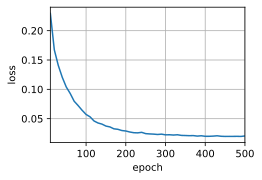

In [5]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 500, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens,
                             num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens,
                                  num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [6]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [7]:
attention_weights = np.concatenate(
    [step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
        (1, 1, -1, num_steps))

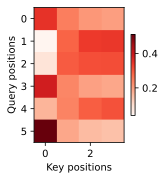

In [8]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1],
                  xlabel='Key positions', ylabel='Query positions')

In [18]:
len(src_vocab), len(tgt_vocab), embed_size, num_hiddens*3,num_hiddens+num_hiddens

(184, 201, 32, 96, 64)

In [15]:
net.collect_params()

encoderdecoder0_ (
  Parameter embedding2_weight (shape=(184, 32), dtype=float32)
  Parameter gru2_l0_i2h_weight (shape=(96, 32), dtype=float32)
  Parameter gru2_l0_h2h_weight (shape=(96, 32), dtype=float32)
  Parameter gru2_l0_i2h_bias (shape=(96,), dtype=float32)
  Parameter gru2_l0_h2h_bias (shape=(96,), dtype=float32)
  Parameter gru2_l1_i2h_weight (shape=(96, 32), dtype=float32)
  Parameter gru2_l1_h2h_weight (shape=(96, 32), dtype=float32)
  Parameter gru2_l1_i2h_bias (shape=(96,), dtype=float32)
  Parameter gru2_l1_h2h_bias (shape=(96,), dtype=float32)
  Parameter dense4_weight (shape=(32, 32), dtype=float32)
  Parameter dense5_weight (shape=(32, 32), dtype=float32)
  Parameter dense6_weight (shape=(1, 32), dtype=float32)
  Parameter embedding3_weight (shape=(201, 32), dtype=float32)
  Parameter gru3_l0_i2h_weight (shape=(96, 64), dtype=float32)
  Parameter gru3_l0_h2h_weight (shape=(96, 32), dtype=float32)
  Parameter gru3_l0_i2h_bias (shape=(96,), dtype=float32)
  Parameter gr